In [1]:
import math
import csv
from numpy import genfromtxt
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

import pandas as pd
# import mysql.connector 

%matplotlib inline
np.random.seed(1)

In [2]:
XY_orig=genfromtxt('gender_14000_preprocessed.csv', delimiter=',') 
XY_orig=np.matrix(XY_orig)          # original .csv dataset
X_orig=XY_orig[1:14001, 0:30].T     # eliminating feature-names, labels, unnecessary features and transpose to get X_orig
Y_orig=XY_orig[1:14001, 30].T       # extracting labels and transpose to get Y
X_orig_max = X_orig.max(1)          # normalizing features
X_orig=X_orig/X_orig_max

X_train=X_orig[:, 0:11200]          # splitting into X_train
Y_train=Y_orig[:, 0:11200]          # splitting into Y_train

X_test=X_orig[:, 11200:14000]       # splitting into X_test
Y_test=Y_orig[:, 11200:14000]       # splitting into Y_test

X_train=np.array(X_train)           # converting to array from matrices
X_test=np.array(X_test)
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)

Y_train=Y_train.astype(int)         # converting to one-hot
Y_test=Y_test.astype(int)
Y_train=convert_to_one_hot(Y_train, 2)
Y_test=convert_to_one_hot(Y_test, 2)

print ("number of training examples = " + str(X_train.shape[1]))      
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 11200
number of test examples = 2800
X_train shape: (30, 11200)
Y_train shape: (2, 11200)
X_test shape: (30, 2800)
Y_test shape: (2, 2800)


In [3]:
# load dummy data for test
df_qres=pd.read_csv("gender_real_world_test.csv") 

# extracting the customers' names from the dataframe to a list
names_orig=list(df_qres["UPPER(customer_name)"])

len_names_orig=len(names_orig)

# replacing spaces with dots
names_original_spaces_dotted=[]
for i in range(0, len_names_orig):
    name=""
    names_orig[i]=str(names_orig[i])
    for j in range(0, len(names_orig[i])):
        if(names_orig[i][j]>='A' and names_orig[i][j]<='Z'): name=name+names_orig[i][j]
        else: name=name+"."
    names_original_spaces_dotted.append(name)

# truncating names/appending dots
names_original_padded=[] 
for i in range(0, len_names_orig):
    name=""
    for j in range(0, 30):
        if(j<len(names_original_spaces_dotted[i])): name=name+names_original_spaces_dotted[i][j]
        else: name=name+'.'
    names_original_padded.append(name)

# representing names in terms of ascii values
names_ascii=[]
for i in range(0, len_names_orig):
    name=names_original_padded[i]
    name_ascii=[]
    for j in range(0, len(name)): name_ascii.append(ord(name[j]))
    names_ascii.append(name_ascii)  
    
# take the preprocessed, normalized, real-world names into a form passable to the computation graph and show dimensions
X_real_world=np.array(names_ascii).T
X_real_world_max = np.max(X_real_world, axis=1, keepdims=True) 
X_real_world=X_real_world/X_real_world_max

print ("number of real world names = " + str(X_real_world.shape[1]))      
print ("X_real_world shape: " + str(X_real_world.shape))

number of real world names = 272
X_real_world shape: (30, 272)


In [4]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    
    return X, Y

In [5]:
def initialize_parameters():
    
    # keeping results consistent
    tf.set_random_seed(1)                   
        
    # defining the neural network's architecture
    W1 = tf.get_variable("W1", [40, 30], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [40, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable("W2", [40, 40], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [40, 1], initializer = tf.zeros_initializer())
    
    W3 = tf.get_variable("W3", [40, 40], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [40, 1], initializer = tf.zeros_initializer())
    
    W4 = tf.get_variable("W4", [10, 40], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b4 = tf.get_variable("b4", [10, 1], initializer = tf.zeros_initializer())
    
    W5 = tf.get_variable("W5", [5, 10], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b5 = tf.get_variable("b5", [5, 1], initializer = tf.zeros_initializer())
    
    W6 = tf.get_variable("W6", [2, 5], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b6 = tf.get_variable("b6", [2, 1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4,
                  "W5": W5,
                  "b5": b5,
                  "W6": W6,
                  "b6": b6}
    
    return parameters

In [6]:
def forward_propagation(X, parameters):
    
    # retrieving the parameters from the dictionary 'parameters' 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    W5 = parameters['W5']
    b5 = parameters['b5']
    W6 = parameters['W6']
    b6 = parameters['b6']
                                         
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              
    A1 = tf.nn.relu(Z1)   
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                             
    A2 = tf.nn.relu(Z2)  
    
    Z3 = tf.add(tf.matmul(W3, A2), b3) 
    A3 = tf.nn.relu(Z3)
    
    Z4 = tf.add(tf.matmul(W4, A3), b4)
    A4 = tf.nn.relu(Z4)
    
    Z5 = tf.add(tf.matmul(W5, A4), b5)
    A5 = tf.nn.relu(Z5)
    
    Z6 = tf.add(tf.matmul(W6, A5), b6)
    
    return Z6

In [7]:
def compute_cost(Z6, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z6)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [8]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.002,
          num_epochs = 1000, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # n_x: input size, m : number of examples in the train set
    n_y = Y_train.shape[0]                            # n_y: output size
    costs = []                                        # to keep track of the cost
    
    # creating Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # initializing parameters
    parameters = initialize_parameters()
    
    # forward propagation: building the forward propagation in the tensorflow graph
    Z6 = forward_propagation(X, parameters)
    
    # cost function: adding cost function to tensorflow graph
    cost = compute_cost(Z6, Y)
    
    # backpropagation: defining the tensorflow AdamOptimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # initializing all the variables
    init = tf.global_variables_initializer()

    # starting the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # running the initialization
        sess.run(init)
        
        # training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # selecting a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # printing the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plotting the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # saving the parameters in a variable
        parameters = sess.run(parameters)
        
        print ("Parameters have been trained!")
        print()

        # accuracy
        correct_prediction = tf.equal(tf.argmax(Z6), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        print()
        
        # confusion matrix
        predicted0_actual0 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z6), 0), tf.equal(tf.argmax(Y), 0)), "float"))
        predicted0_actual1 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z6), 0), tf.equal(tf.argmax(Y), 1)), "float"))
        predicted1_actual0 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z6), 1), tf.equal(tf.argmax(Y), 0)), "float"))
        predicted1_actual1 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z6), 1), tf.equal(tf.argmax(Y), 1)), "float"))

        print("True negatives:", predicted0_actual0.eval({X: X_test, Y: Y_test}))
        print("False negatives:", predicted0_actual1.eval({X: X_test, Y: Y_test}))
        print("False positives:", predicted1_actual0.eval({X: X_test, Y: Y_test}))
        print("True positives:", predicted1_actual1.eval({X: X_test, Y: Y_test}))
        print()

        # precision, recall
        recall=tf.divide(predicted1_actual1, tf.add_n([predicted1_actual1, predicted0_actual1]))
        precision=tf.divide(predicted1_actual1, tf.add_n([predicted1_actual1, predicted1_actual0]))
        
        print("Train Precision:", precision.eval({X: X_train, Y: Y_train}))
        print("Test Precision:", precision.eval({X: X_test, Y: Y_test}))
        print("Train Recall:", recall.eval({X: X_train, Y: Y_train}))
        print("Test Recall:", recall.eval({X: X_test, Y: Y_test}))
        print()
        
        # accuracy on 0s (females)
        accuracy_females=tf.divide(predicted0_actual0, tf.add_n([predicted0_actual0, predicted1_actual0]))

        print("Test accuracy on females:", accuracy_females.eval({X: X_test, Y: Y_test}))
        print()
        
        # cases where 0s (females) were predicted 
        predicted0=tf.equal(tf.argmax(Z6), 0)
        
        predicted_zeros=list(predicted0.eval({X: X_real_world}))
        len_predicted_zeros=len(predicted_zeros)
        for i in range(0, len_predicted_zeros):
            if(predicted_zeros[i]==True): predicted_zeros[i]="female"
            else: predicted_zeros[i]="male"
        
        # add the learned gender to the query result
        df_qres['computed_gender']=predicted_zeros
        
        return parameters


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 0.655032
Cost after epoch 100: 0.415022
Cost after epoch 200: 0.373353
Cost after epoch 300: 0.342798
Cost after epoch 400: 0.297631
Cost after epoch 500: 0.282234
Cost after epoch 600: 0.277760
Cost after epoch 700: 0.251362
Cost after epoch 800: 0.240860
Cost after epoch 900: 0.227271


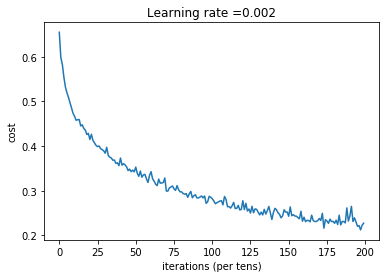

Parameters have been trained!

Train Accuracy: 0.91151786
Test Accuracy: 0.8182143

True negatives: 1186.0
False negatives: 256.0
False positives: 253.0
True positives: 1105.0

Train Precision: 0.917535
Test Precision: 0.8136966
Train Recall: 0.90565705
Test Recall: 0.811903

Test accuracy on females: 0.82418346



In [9]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [10]:
# subset out females and output as csv
df_qres=df_qres[df_qres.computed_gender=="female"]
df_qres.to_csv("gender_computed_pitch_BTY.csv", index = False, header=True)